In [1]:
from sunpy.net import Fido, attrs as a
from astropy import units as u
import matplotlib.pyplot as plt
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
# import glob
# from stixpy.net import client
# import sunpy_soar

In [65]:
flare_time_range = ['2013-11-09 06:38:00', '2013-11-09 06:38:11']

# Band  FWHM    Primary role,                                           Typical Temperature
# (Å)   (Δλ, Å) ion(s)          Region of the Sun's atmosphere	        (as log T[K])
# 
# 335   16.5	Fe xvi	        Active region corona	                6.4
# 304   12.7	He ii	        Chromosphere, transition region	        4.7
# 211	7.0	    Fe xiv	        Active region corona	                6.3
# 193	6.0	    Fe xii, xxiv	Corona and hot flare plasma	            6.1, 7.3
# 171	4.7	    Fe ix	        Quiet corona, upper transition region   5.8
# 131	4.4	    Fe xx, xxiii	Flaring regions	                        7.0, 7.2
# 94	0.9	    Fe xviii	    Flaring regions	                        6.8

wavelength = 335  # Active region corona                      - 
# wavelength = 304  # Chromosphere, transition region           - interesting, footpoints?
# wavelength = 211  # Active region corona                      - nice, but not much flare
# wavelength = 193  # Corona and hot flare plasma               - nice, but not much flare
# wavelength = 171  # Quiet corona, upper transition region     - good
# wavelength = 131  # Flaring regions                           - good
# wavelength = 94   # Flaring regions                           - trash

result = Fido.search(
    a.Time(flare_time_range[0], flare_time_range[-1]),
    a.Instrument("AIA"), 
    a.Wavelength(wavelength * u.angstrom),
    a.Sample(1/60 * u.min)
)

aia_fits_path = Fido.fetch(result, path = 'aia_data')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_335a_2013_11_09t06_38_02_62z_image_lev1.fits:   0%|          | 0.00/7.55M [00:00<?, ?B/s]

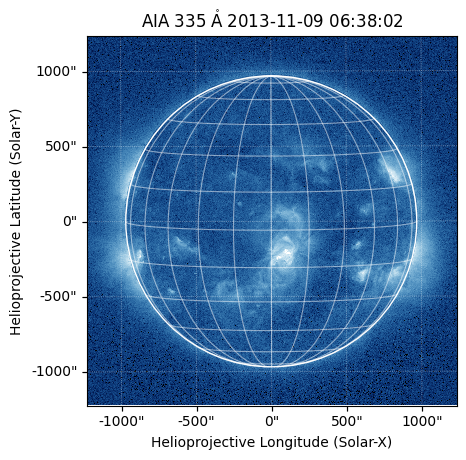

In [67]:
plot_font = {'fontname':'Times New Roman'}

aia_map = sunpy.map.Map(aia_fits_path[0])
aia_map.plot(clip_interval=(0.1, 99.99)*u.percent)

normalise = False

if normalise:
    norm = ImageNormalize(vmin=0, vmax=200, stretch=SqrtStretch())
    aia_map.plot(norm=norm)
    normalised = "_normalised"
else:
    normalised = ""

aia_map.draw_limb()
aia_map.draw_grid()

# Drawing boxes
# ax = [300, -750, -450]
# ay = [-500, 50, -150]
# bx = [550, -500, -300]
# by = [-300, 250, 0]
# bottom_left_94 = SkyCoord(ax[0]*u.arcsec, ay[0]*u.arcsec, frame=aia_map.coordinate_frame)
# top_right_94 = SkyCoord(bx[0]*u.arcsec, by[0]*u.arcsec, frame=aia_map.coordinate_frame)
# aia_map.draw_quadrangle(bottom_left_94, top_right=top_right_94, axes=ax1, color='cyan', linewidth=2)

plt.savefig(f"plots/2013_well_observed_flare_AIA_{wavelength}a{normalised}.png", format='png', bbox_inches='tight', dpi=300)
plt.show()